# TD7: Searching for steady states

The goal of this TD is to get familiar with a few techniques that allow you to find the steady states of a dynamical system from a numerical point of view.

We will be interested in the following differential equation:
$$
    \dot{x} = -x^3 + 5x + \mu,
$$
that depends on a real parameter $\mu$. Here, the steady states are simply the roots of the polynomial $f_\mu(x) = -x^3 + 5x + \mu$. Depending on the value of $\mu$, there can be one, two or three real roots.

We will need the usual Python packages:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Part 1: Runge-Kutta approach: an uncomplete bifurcation diagram

A first approach to find the steady states of a dynamical system is to draw some various initial conditions and integrate the corresponding Cauchy problems for a sufficient long time. This time has to be long enough to reach a steady state, at least approximately.

*Note that in general, a solution of a dynamical system is not guaranteed to converge, but for our particular system any solution will converge to a steady state (can you see why?).*

We thus want to solve multiple Cauchy problems such as:
$$
\begin{cases}
    \dot{x} &= f_\mu (x)\\
    x (0) &= x_0
\end{cases}
$$
with $x_0$ chosen from a set of relevant values $\{x_0^{(1)}, ..., x_0^{(m)}\}$.

We will use a Runge-Kutta method to integrate these systems. We recall the RK4 method (Runge-Kutta method of fourth order) that computes the value of the numerical solution $x (t)$ as follows:
$$
\begin{align}
    X_1 &= \Delta t~f_\mu\left(x (t)\right)\\
    X_2 &= \Delta t~f_\mu\left(x(t) + \frac{X_1}{2}\right)\\
    X_3 &= \Delta t~f_\mu\left(x(t) + \frac{X_2}{2}\right)\\
    X_4 &= \Delta t~f_\mu\left(x(t) + X_3\right)\\
    x (t + \Delta t) &= x (t) + \frac1{6}(X_1 + 2X_2 + 2X_3 + X_4)
\end{align}
$$

For a given initial condition $x_0$, we will solve the Cauchy problem on $[0, T]$, with $T$ big enough to claim that the numerical solution has approximately converged. In practice, we can use the following criterion to define $T$: let $T$ be the smallest positive number such as $|f_\mu(x(T))| \leq \sigma$, with $\sigma$ an arbitrary threshold .

**1)** Define a $rk4$ function which returns the value of $x(t+\Delta t)$ in function of $x(t)$, $f$, and $\Delta t$ using the previous Runge-Kutta method.

In [20]:
def fun_third(x, mu):
    return -x**3 + 5*x + mu

In [3]:
def rk4_step(f, dt, xt):
    X1 = dt * f(xt)
    X2 = dt * f(xt + X1/2)
    X3 = dt * f(xt + X2/2)
    X4 = dt * f(xt + X3)
    return xt + (X1 + 2*X2 + 2*X3 + X4)/6

**2)** For given values of $\mu$, $x_0$ and $\sigma$, integrate the system on $[0,T]$. We will plot the corresponding solution. Give an approximate value of the steady state $x_\infty$ reached by this solution.

In [26]:
def rk4(f, x0, dt=0.01, sigma=0.01, max_iter_flag=True, max_iter=1000, verbose=False, ret_all=False, n_ret=1):
    x = np.array([x0])
    
    if max_iter_flag:
        i = 0
        while (i < max_iter) and (np.abs(f(x[i])) > sigma):
            x = np.append(x, rk4_step(f, dt, x[i]))
            i += 1
    else:
        i = 0
        while np.abs(f(x[i])) > sigma:
            x = np.append(x, rk4_step(f, dt, x[i]))
            i += 1
    
    if verbose:
        if max_iter_flag and max_iter_flag and (i == max_iter):
            print('Max Iter Number Reached')
        else:
            print('Below Treshold for i={}'.format(i))
            
        if ret_all:
            return x
        else:
            return x[-n_ret:]
    else:
        if ret_all:
            return x
        else:
            return x[-n_ret:]

Now that we know how to integrate our system and to approximate its steady states, we want to describe the dependence of the steady states to the $\mu$ parameter. We want to build a **bifurcation diagram**, which represents the steady states $x_\infty$ as a function of $\mu$ (there can be several steady states for a given value of $\mu$ as mentioned above).

**3)** Plot the bifurcation diagram of this dynamical system. We can typically probe values of $\mu$ that range from $-10$ to $10$, and for each of these values, probe values of $x_0$ that range from $-5$ to $5$.

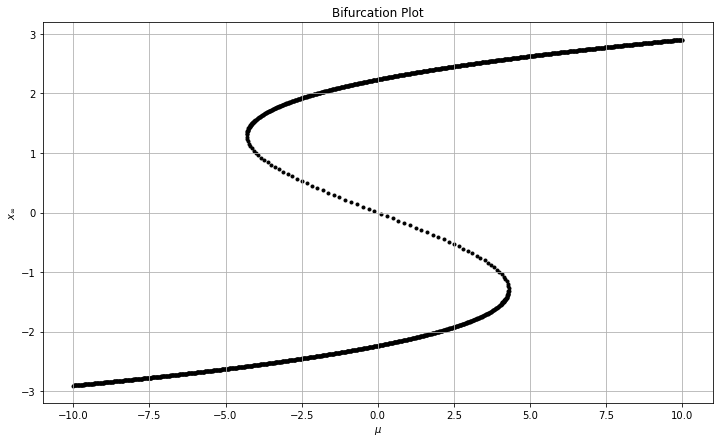

In [23]:
def bif_diag_rk4(f, dt=0.01, sigma=0.01, mu_range=[-10, 10], mu_steps=1024, x0_range = [-5, 5], x0_steps = 256):
    """
    The function f should have x has first argument and mu has second argument.
    """
    x0s = np.linspace(x0_range[0], x0_range[1], x0_steps)
    mus = np.linspace(mu_range[0], mu_range[1], mu_steps)
    
    plt.figure(figsize = (12, 7))
    for i in range(len(mus)):
        asymp = np.empty((1,))
        
        first_flag = True
        for j in range(len(x0s)):    
            tmp = rk4(lambda x: f(x, mus[i]), x0s[j], dt=dt, sigma=sigma, max_iter_flag=False)
            
            if first_flag:
                asymp[0] = tmp
                first_flag = False
            
            foo = tmp*np.ones(asymp.shape)
            
            if not ((np.abs(asymp - foo) < 0.01).any()):
                asymp = np.append(asymp, tmp)
        
        plt.scatter(mus[i]*np.ones(asymp.shape), asymp, marker='.', color='black')
    
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$x_{\infty}$")
    plt.grid()
    plt.title('Bifurcation Plot')

bif_diag_rk4(fun_third)

**4)** Can we find all the steady states of our system for a given value of $\mu$ with this method?

## Part 2: Newton's method: a complete bifurcation diagram

We need another technique if we want to find the unstable steady states. **Newton's method** is a general technique that find the zeros of a function independently of how stable these zeros are in the context of a dynamical system.

For a function $f$ defined over the real numbers, starting from a real $x_0$, Newton's method converges towards a zero of $f$ through the following recurrent sequence:
$$
    x_{n+1} = x_n - \frac{f(x_n)}{f^\prime(x_n)}
$$
Obviously the choice of $x_0$ will be determinant to the limit value of the previous sequence. We will need to try several initial conditions to find every zero of $f$.

**5)** Build a *newton* routine that computes the value of $x_{n+1}$ as a function of $f$, $f^\prime$ and $x_n$.

In [25]:
def newton(x, f, d, reg=True):
    if reg:
        eps = 1e-6
        return x - f(x)/(d(x) + eps)
    else:
        return x - f(x)/d(x)

**6)** Observe Newton's method quadratic convergence to a zero of $f_\mu$ polynomial printing $\left(f_\mu\left(x_n\right)\right)_n$ first terms for given values of $x_0$ and $\mu$. Do we always have a quadratic convergence of this method?

In [9]:
def deriv(x):
    return -3*x**2 + 5

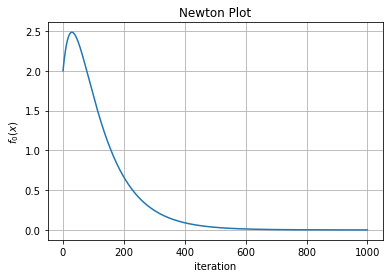

In [10]:
def newton_convergence(x0, mu, steps):
    xs = np.array([x0])
    
    for i in range(steps):
        x = newton(xs[i], lambda x: fun(x, mu), deriv)
        xs = np.append(xs, x)
    
    plt.plot(fun(xs, mu))
    plt.xlabel("iteration")
    plt.ylabel(r'$f_{{{0}}}(x)$'.format(mu))
    plt.grid()
    plt.title('Newton Plot')

newton_convergence(1, 0, 1000)

**7)** Plot a new bifurcation diagram of our dynamical system using Newton's method. Does it seem complete now?

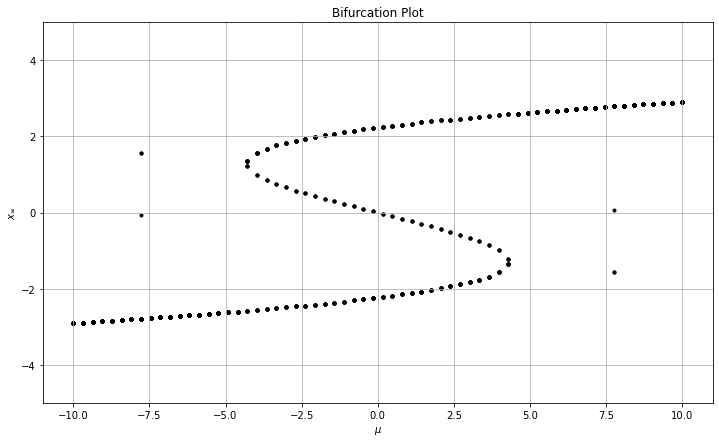

In [27]:
def bif_diag_newton(f, der, steps=300, mu_range=[-10, 10], mu_steps=64, x0_range = [-5, 5], x0_steps = 16):
    """
    The function f should have x has first argument and mu has second argument.
    """
    x0s = np.linspace(x0_range[0], x0_range[1], x0_steps)
    mus = np.linspace(mu_range[0], mu_range[1], mu_steps)
    
    plt.figure(figsize = (12, 7))
    for i in range(len(mus)):
        for j in range(len(x0s)):
            asymp = x0s[j]
            for k in range(steps):
                #asymp = newton(asymp, lambda x: f(x, mus[i]), der)
                asymp = newton(asymp, lambda x: f(x, mus[i]), der, reg=True)
                #asymp - fun(asymp,mus[i])/deriv(asymp)
            plt.scatter(mus[i], asymp, marker='.', color='black')
            
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$x_{\infty}$")
    plt.grid()
    plt.ylim([-5,5])
    plt.title('Bifurcation Plot')
    
bif_diag_newton(fun_third, deriv)

## Bonus part: The Newton fractal

The [Newton fractal](https://en.wikipedia.org/wiki/Newton_fractal) is a fractal figure which stems from the application of Newton's method to the following complex polynomial:
$$
    f(z) = z^3 - 1
$$
The roots of the previous polynomial are well known, these are the third roots of unity: $\{1, e^{\frac{2i\pi}{3}}, e^{-\frac{2i\pi}{3}}\}$. Still, it is interesting to approximate these roots with a Newton's method applied to a regulard grid of initial values in the complex plane as spectacular properties of convergence come out from Newton's algorithm.

In the following, we will identify $\mathbb{C}$ to $\mathbb{R}^2$ for pedagogical purposes. Therefore Newton's method is to be applied to a function $f:\mathbb{R}^2\rightarrow\mathbb{R}^2$ defined as follows:
$$
    f (x, y) = \left( \begin{array}{c} f_1 (x,y) \\ f_2 (x,y)\end{array}\right) = \left( \begin{array}{c} \Re\left(\left(x+iy\right)^3 - 1\right) \\ \Im\left(\left(x+iy\right)^3 - 1\right)\end{array}\right)
$$
where $\Re$ and $\Im$ respectively denotes the real and imaginary part of a given complex number.

For a vector-valued function such as above $f$ function, Newton's method can be written as follows:
$$
    X_{n+1} = X_n - \left[\text{D}f(X_n)\right]^{-1}f(X_n)
$$
where $X_n$ is a vector (of dimension 2 for above $f$ function) and $\text{D}f(X_n)$ is the Jacobian matrix of $f$ at $X_n$. We recall the general expression of the Jacobian matrix for a function $f:\mathbb{R}^m\rightarrow\mathbb{R}^m$:
$$
    \text{D}f(X) = \left(\frac{\partial f_i}{\partial x_j}(X)\right)_{i, j\in\{1,...,m\}}
$$

**8)** What are the analytical expressions of $f$ and $\text{D}f$?

By saying that the actual vector of $\mathbb{R}^2$ is $X$ and the two components are $x$ and $y$ the expression for the function:
$$
f(x, y) = \begin{pmatrix}x^3 - 3 y^2 x -1 \\ 3x^2 y - y^3 \end{pmatrix} 
$$
and the jacobian:
$$
\frac{\partial \{f_1, f_2\}}{\partial \{ x,y\}}(x,y) = \begin{pmatrix} 3x^2 - 3y^2 & - 6 y x \\ 6xy & 3x^2 -3y^2\end{pmatrix}
$$

**9)** Perform Newton's method on $f$ for a dense enough 2D grid of initial conditions and for a uniform number of Newton iterations. We will use [scipy.linalg.inv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.inv.html) function to invert the Jacobian matrix.

In [43]:
import scipy.linalg as la

def jacobian(point):
    x = point[0]
    y = point[1]
    return np.array([[3*x**2 - 3*y**2, -6*x*y] , [6*x*y, 3*x**2 - 3*y**2]])

def function(point):
    x = point[0]
    y = point[1]
    return np.array([x**3 - 3*x*y**2 - 1,3*x**2*y - y**3])

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))

origin = np.array([0,0])

In [44]:
def newton_2d(init_point, f, jac, sigma=0.01, max_iter=1000):
    point = init_point
    i = 0
    while dist(f(point),origin) > sigma or i > max_iter:
        D = jac(point)
        point = point - np.dot(la.inv(D), f(point))
        i += 1
    return point

**10)** Plot using [pcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html) function for each point of the previous grid of initial conditions the complex argument of the final term of the Newton sequence (we can use [numpy.angle](https://docs.scipy.org/doc/numpy/reference/generated/numpy.angle.html) function to do that). You should observe a fractal figure called the *Newton fractal*. Does Newton's method always converge in this case?

In [45]:
def print_newton_fractal(size=512, x_range=[-5,5], y_range=[-5,5]):
    xs = np.linspace(x_range[0], x_range[1], size)
    ys = np.linspace(y_range[0], y_range[1], size)
    
    frac = np.empty((size, size))
    for i in range(size):
        for j in range(size):
            point = newton_2d([xs[i], ys[j]], function, jacobian, sigma=1e-2)
            frac[i,j] = np.angle(point[0] + 1j * point[1])
    
    plt.pcolor(frac)
    plt.show()

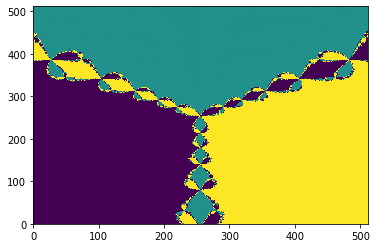

In [46]:
print_newton_fractal()